## CS 889 Assignment 04
### Yuwei Jiao 20645480

### Objective 1
### description:
- problem:
    1. Unable to set the width and height of frame. Tried several methods but failed.
    2. Set proper brightness range.
- exploration:
    1. Tried to capture different colors. Red need to be dealt with differently because Hue distributes around 0. Therefore it's composed of two parts: [170, 180] and [0, 10]. Dark black is special too because Hue and Saturation are not as important as Value. As long as Value keeps low, the color looks dark.
    2. To track bright colors, Hue could be any value but Saturation and Value should be high. Here I set Saturation ranges from 100 to 255 while Value ranges from 150 to 255.
    3. Tried planar objects(dark wallet surface and green chocolate cover). It's hard to capture the shape completely because planar surface leads more reflection effects and changes the color.
    4. To track multiple colors we can simply generate masks and do bitwise operation.
- resources: 
    1. Use this [link][1] to help RGB to HSV colorspace conversion    
[1]: (http://www.rapidtables.com/convert/color/rgb-to-hsv.htm)

In [1]:
%matplotlib inline
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from helpers import imshow

In [2]:
def colorTracker1(lowerColor, upperColor):
    camera = cv2.VideoCapture(0)
    blurKernel = np.ones((5,5),np.float32) / 25
    morKernel = np.ones((3,3),np.uint8) / 9
    while True:
        # Step 1: Capture and display cleaned-up frames
        _, ori = camera.read()
        ori = np.fliplr(ori)
        frame = ori.copy()
        frame = cv2.filter2D(frame, -1, blurKernel)
        frame = cv2.medianBlur(frame, 5)
        # Step 2: Convert colorspace from BGR to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # Step 5: Create a mask
        mask = cv2.inRange(hsv, lowerColor, upperColor)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, morKernel, iterations = 4)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, morKernel, iterations = 2)
        frame = ori.copy()
        # Step 6: Find blobs
        _, contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < 800:
                continue
            cv2.drawContours(frame, [cnt], 0, (0, 225, 225), 2)
            M = cv2.moments(cnt)
            position = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
            output = "(" + str(position[0]) + ", " + str(position[1]) + ") " + str(area)
            cv2.putText(frame, output, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
        cv2.imshow('result', frame)
        key = cv2.waitKey(5)
        if key == 27:
            cv2.destroyAllWindows()
            camera.release()
            break
        elif key == 13:
            imshow(frame, 'captured image')
            imshow(mask, 'mask')

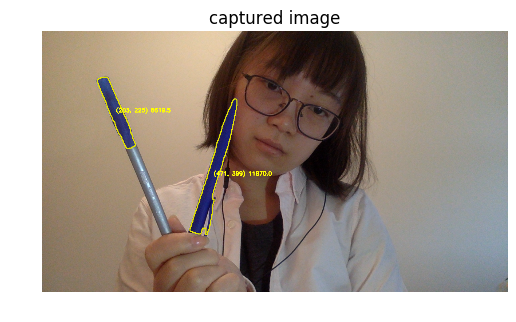

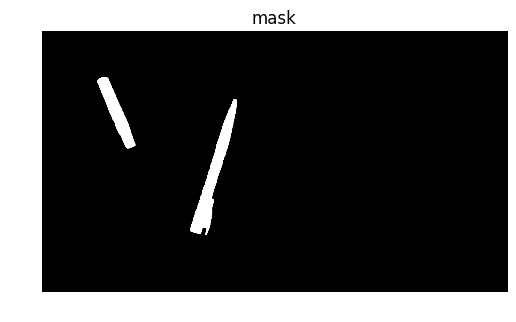

In [ ]:
# Step 3 & 4: Blue
lowerColor = np.array([110, 50, 50])
upperColor = np.array([130, 255, 255])
colorTracker1(lowerColor, upperColor)

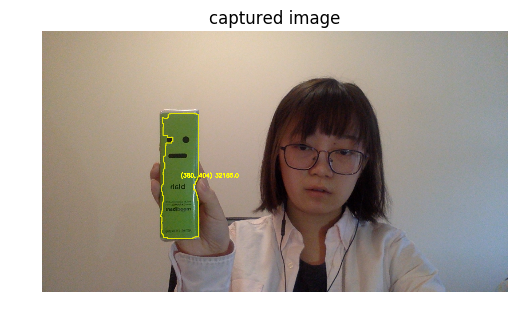

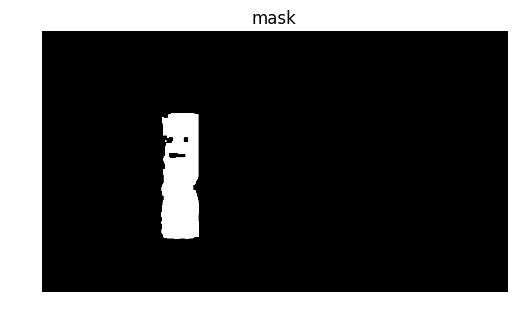

In [4]:
# Step 3 & 4: Green
lowerColor = np.array([40, 50, 50])
upperColor = np.array([60, 255, 255])
colorTracker1(lowerColor, upperColor)

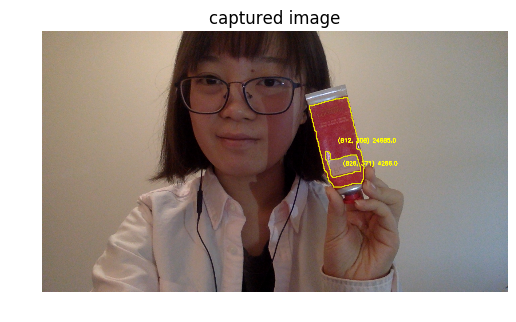

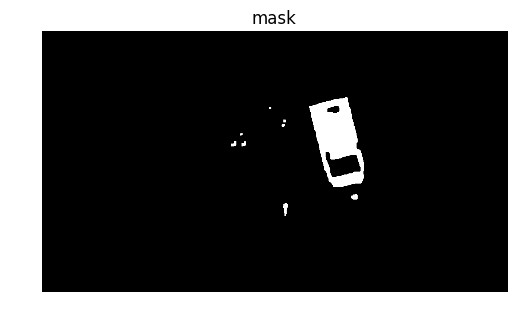

In [ ]:
# Step 3 & 4: Red
lowerColor = np.array([170, 100, 100])
upperColor = np.array([180, 200, 200])
colorTracker1(lowerColor, upperColor)

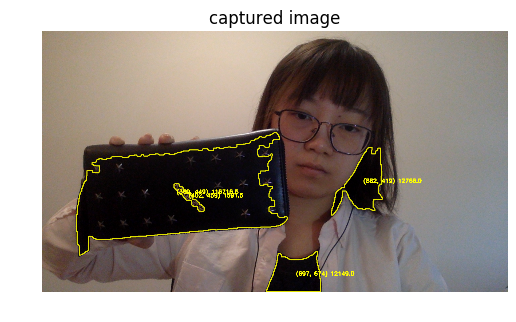

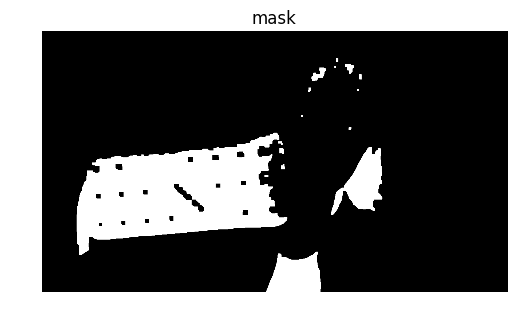

In [ ]:
# Step 3 & 4: Black
lowerColor = np.array([0, 0, 0])
upperColor = np.array([180, 255, 20])
colorTracker1(lowerColor, upperColor)

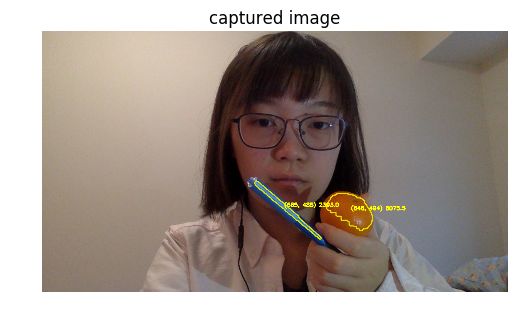

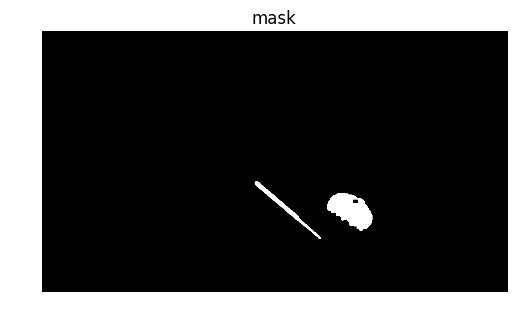

In [3]:
# Step 3 & 4: Bright
lowerColor = np.array([0, 100, 150])
upperColor = np.array([180, 255, 255])
colorTracker1(lowerColor, upperColor)

### Objective 2
### description:
- problem:
    1. The width of frame is horizontal size and height is vertical. For the shape of a frame, the three values are: height, width, channels.
    2. Applied threshold to generate a mask.
- exploration:
    1. Tried different bin size. It seems the fewer bins there are, the smoother the object edges become. With 64 bins the image becomes messy. 
    2. Tried to use Hue and Value but couldn't see any obvious difference.
- resources: 
    1. use this [link][1] to learn about histogram backprojection.
[1]: (http://docs.opencv.org/trunk/dc/df6/tutorial_py_histogram_backprojection.html)

In [3]:
def colorTracker2(binSize, hsvMode):
    camera = cv2.VideoCapture(0)
    blurKernel = np.ones((5,5),np.float32) / 25
    morKernel = np.ones((3,3),np.uint8) / 9
    leftupper = (200, 100)
    rightlower = (300, 200)
    trainFlag = False
    while True:
        _, ori = camera.read()
        ori = np.fliplr(ori)
        frame = ori.copy()
        frame = cv2.filter2D(frame, -1, blurKernel)
        frame = cv2.medianBlur(frame, 5)
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        frame = ori.copy()
        if trainFlag:
            # Step 4: Calculate backprojection
            mask = cv2.calcBackProject([hsv], hsvMode, hist, [0,180,0,256], 1) 
            # Step 5: Generate mask
            _, mask = cv2.threshold(mask, 50, 255, 0)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, morKernel, iterations = 4)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, morKernel, iterations = 2)
            # Step 6: Find blobs
            _, contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area < 800:
                    continue
                cv2.drawContours(frame, [cnt], 0, (0, 225, 225), 2)
                M = cv2.moments(cnt)
                position = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
                output = "(" + str(position[0]) + ", " + str(position[1]) + ") " + str(area)
                cv2.putText(frame, output, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  
        # Step 1: Define a small detecting area
        cv2.rectangle(frame, leftupper, rightlower, (255, 255, 255), 2)
        cv2.imshow('result', frame)
        key = cv2.waitKey(5)
        if key == 27: # esc
            cv2.destroyAllWindows()
            camera.release()
            break
        elif key == 13: # enter
            imshow(frame, 'captured image')
            imshow(mask, 'mask')
        elif key == 32: #space
            trainFlag = True
            # Step 2: Train 2D histogram
            mask = np.zeros(frame.shape[0:2], np.uint8)
            mask[leftupper[1] : rightlower[1], leftupper[0] : rightlower[0]] = 255
            print('bin size = {0}, mode = {1}'.format(str(binSize), ' '.join(str(hsvMode))))
            # Step 3: Write images for debugging
            imshow(frame, 'frame')
            imshow(frame[leftupper[1] : rightlower[1], leftupper[0] : rightlower[0], 0 : 3], 'train region')
            hist = cv2.calcHist([frame], [0], mask, [binSize], [0,256])
            cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
            plt.plot(hist)
            plt.xlim([0, binSize + 1])
            plt.show()


bin size = 16, mode = [ 0 ,   1 ]


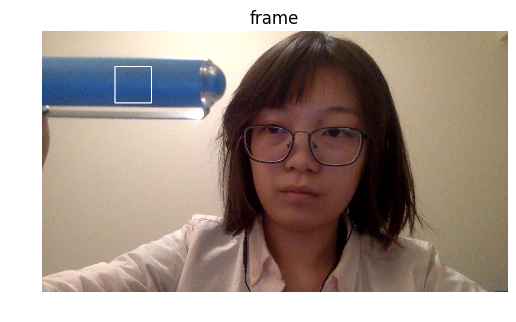

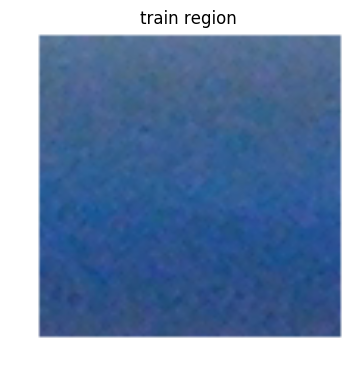

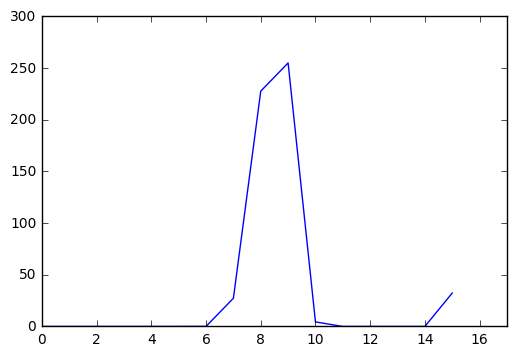

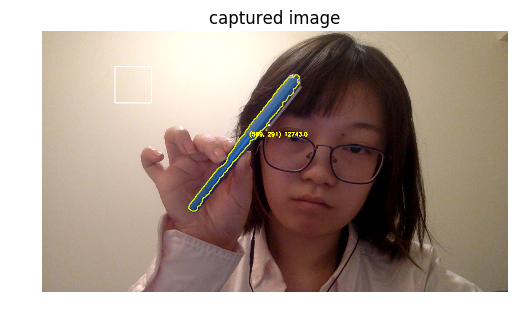

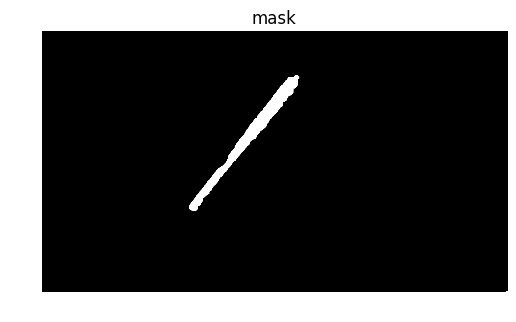

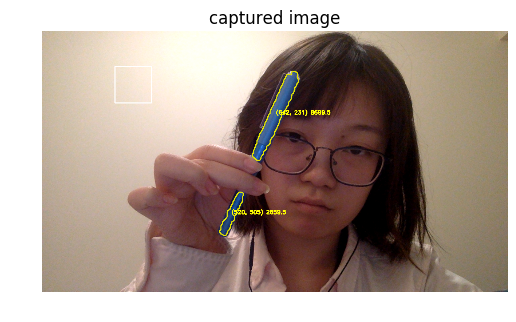

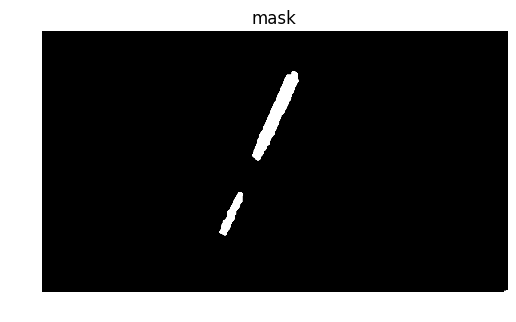

In [ ]:
colorTracker2(16, [0,1])

bin size = 4, mode = [ 0 ,   1 ]


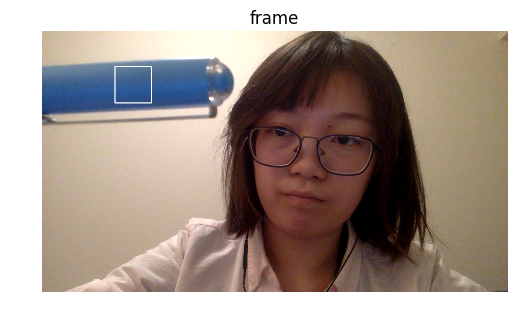

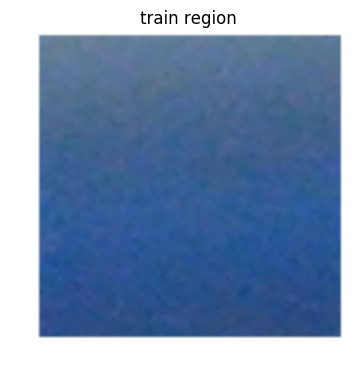

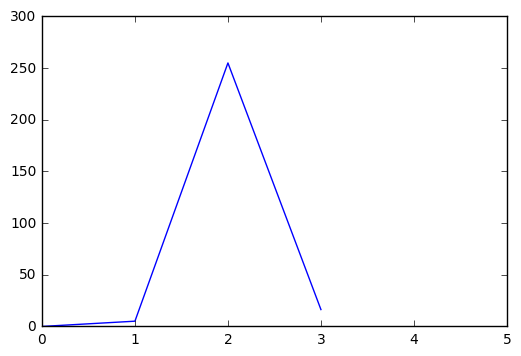

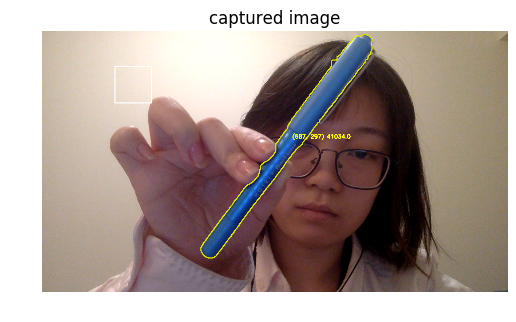

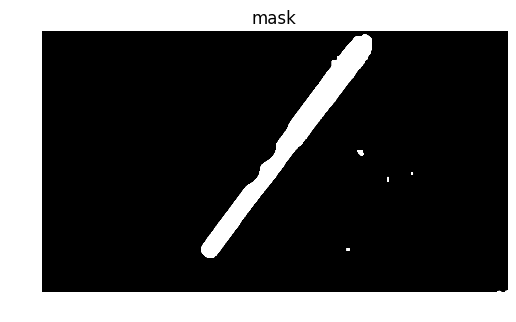

In [ ]:
colorTracker2(4, [0,1])

bin size = 64, mode = [ 0 ,   1 ]


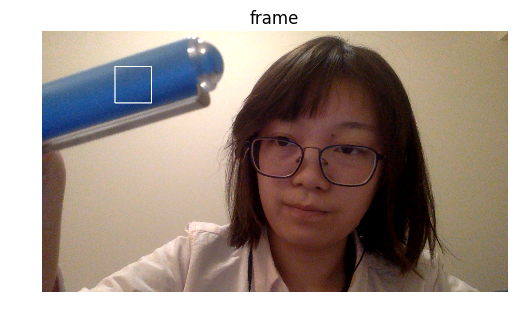

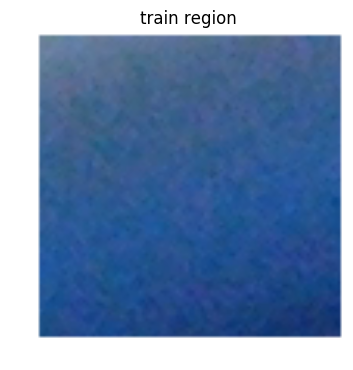

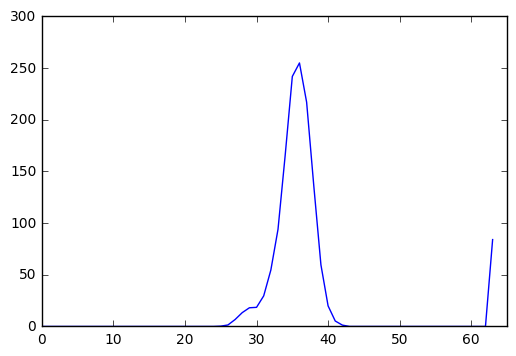

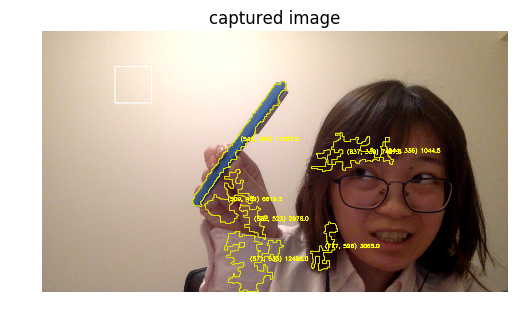

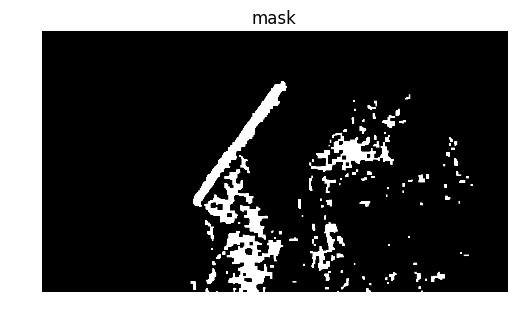

In [ ]:
colorTracker2(64, [0,1])

bin size = 16, mode = [ 0 ,   2 ]


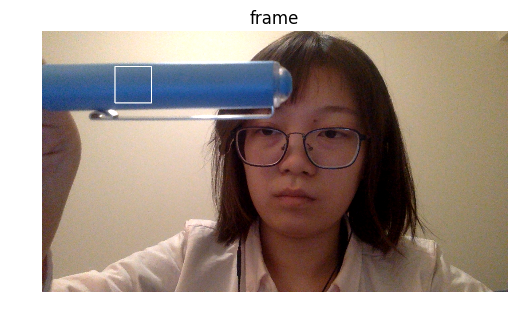

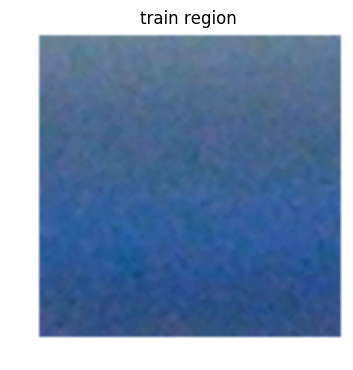

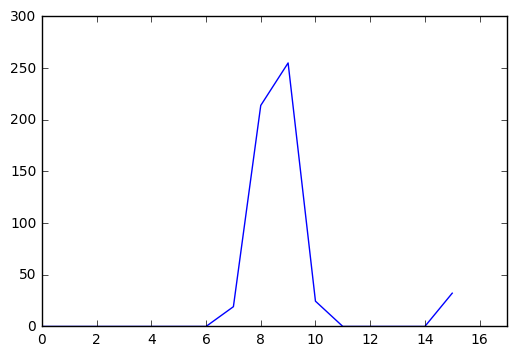

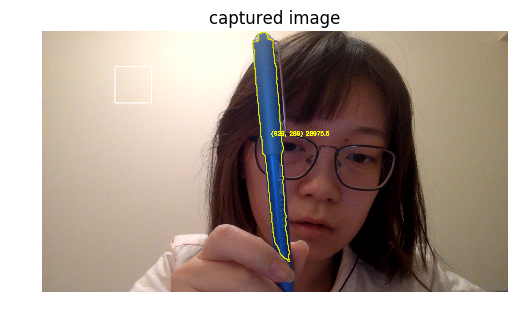

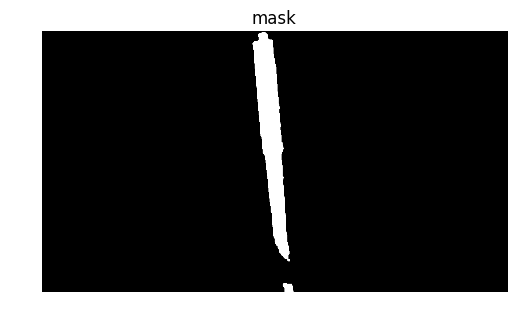

In [4]:
colorTracker2(16, [0,2])